In [1]:
%matplotlib inline
import numpy as np
import scipy.linalg as la
import mpl_toolkits.mplot3d
import matplotlib.pyplot as plt

from numpy.linalg import cond, norm

from scipy.special import sph_harm

import pandas as pd

import pickle
import os.path

In [2]:
n = 200

n_grid = 100

def rbf(r):
    return r**7

deg = 1

def foo(node):
    x, y, z = node
    return np.exp(-(x)**2)

In [3]:
def dist(node1, node2):
    return np.sqrt( (node1[0]-node2[0])**2 + (node1[1]-node2[1])**2 + (node1[2]-node2[2])**2 )

def cart_to_sphere(nodes):
    xs, ys, zs = nodes[:,0], nodes[:,1], nodes[:,2]
    phis = np.arctan2(zs, np.sqrt(1-zs**2))
    thetas = np.arctan2(ys, xs)
    return np.block([[thetas], [phis]]).T

def sphere_to_cart(nodes):
    thetas = nodes[:,0]
    phis = nodes[:,1]
    
    xs = np.cos(phis)*np.cos(thetas)
    ys = np.cos(phis)*np.sin(thetas)
    zs = np.sin(phis)
    
    return np.block([[xs], [ys], [zs]]).T

def sphere_basis(nodes, degree=0):
    n = len(nodes)
    sphereical_nodes = cart_to_sphere(nodes)
    thetas = sphereical_nodes[:,0]
    phis = sphereical_nodes[:,1]
    
    # (m+2)*m + 1 total functions in the basis
    P = np.zeros((n, (degree+2)*degree + 1))
    col = 0
    for l in range(degree+1):
        for m in range(1,l+1):
            P[:, col] = np.real( (0+1j) * (sph_harm(-m, l, thetas, phis) + sph_harm(m, l, thetas, phis) ) )
            col += 1
        P[:, col] = np.real(sph_harm(0, l, thetas, phis))
        col += 1
        for m in range(1,l+1):
            P[:, col] = np.real(sph_harm(-m, l, thetas, phis) - sph_harm(m, l, thetas, phis) )
            col += 1
    return P[:,0:col]

# Generate Nodes

In [4]:
indices = np.arange(0, n, dtype=float) + 0.5
phi = np.arccos(1 - 2*indices/n)
theta = np.pi * (1 + 5**0.5) * indices
xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
nodes = np.array([(x,y,z) for x,y,z in zip(xs,ys,zs)])

# Calculate Weights

In [5]:
A = np.array([[rbf(dist(node, node_center)) for node in nodes] for node_center in nodes])
P = sphere_basis(nodes, degree=deg)
num_terms = len(P[0])
AP = np.block([[A, P],[P.T, np.zeros((num_terms,num_terms))]])
f = np.array([foo(node) for node in nodes] + [0]*num_terms)

ws = la.solve(AP, f)

# Interpolate and Caculate Error

In [6]:
thetas, phis = np.meshgrid( np.linspace(0,2*np.pi, n_grid), np.linspace(-np.pi/2, np.pi/2, n_grid))
thetas = thetas.ravel()
phis = phis.ravel()
#new_nodes = np.array([thetas,phis]).reshape((2, n_grid**2))
new_nodes = sphere_to_cart(np.array([thetas,phis]).T)

A = np.array([[rbf(dist(node, node_center)) for node in nodes] for node_center in new_nodes])
P = sphere_basis(new_nodes, degree=deg)
num_terms = len(P[0])
AP = np.block([[A, P]])
f_true = np.array([foo(node) for node in new_nodes])

errors = AP@ws - f_true

print(np.max(np.abs(errors)))
print(norm(errors/f_true))

0.0004573495340933764
0.006365793559458735


# Loop testing

## Functions

In [20]:
rbf_dict = {}

even_tol = 1e-14

def rbf(r):
    return r**3
def d_phi_dr_div_r(r):
    return 3 * r
rbf_dict['r^3'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**2 * (1 + 4*np.log(r))
rbf_dict['r^4*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**5
def d_phi_dr_div_r(r):
    return 5 * r**3
rbf_dict['r^5'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**4 * (1 + 6*np.log(r))
rbf_dict['r^6*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**7
def d_phi_dr_div_r(r):
    return 7 * r**5
rbf_dict['r^7'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    if abs(r)< even_tol:
        return 0
    return r**8 * np.log(r)
def d_phi_dr_div_r(r):
    if abs(r)< even_tol:
        return 0
    return r**6 * (1 + 8*np.log(r))
rbf_dict['r^8*log(r)'] = (rbf, d_phi_dr_div_r)

def rbf(r):
    return r**9
def d_phi_dr_div_r(r):
    return 9 * r**7
rbf_dict['r^9'] = (rbf, d_phi_dr_div_r)

# RBFs with Shape Parameter
shape_rbfs = []

def rbf(r):
    return np.exp(-(epsilon*r)**2)
def d_phi_dr_div_r(r):
    return -2 * epsilon**2 * np.exp(-(epsilon*r)**2)
rbf_dict['gaussian'] = (rbf, d_phi_dr_div_r)
shape_rbfs += ['gaussian']

## Loop Parameters

In [21]:
file_name = 'survey'

ns = [20 * 2**i for i in range(3, 8)]

n_grid = 50

rbf_labels = ['r^3', 'r^4*log(r)', 'r^5', 'r^6*log(r)', 'r^7', 'r^8*log(r)', 'r^9']
#rbf_labels = ['r^3', 'r^5', 'r^9']

degs = [0, 1, 2, 3]

def foo(node):
    x, y, z = node
    return np.exp(-(x)**2)

In [22]:
columns = ['rbf', 'degree', 'N', 'max_error', 'rel_L2_error']
data = pd.DataFrame(columns=columns)

# solution
thetas, phis = np.meshgrid( np.linspace(0,2*np.pi, n_grid), np.linspace(-np.pi/2, np.pi/2, n_grid))
thetas = thetas.ravel()
phis = phis.ravel()

new_nodes = sphere_to_cart(np.array([thetas,phis]).T)
f_true = np.array([foo(node) for node in new_nodes])

#generate nodes
for n in ns:
    print('n = %d' % n)
    indices = np.arange(0, n, dtype=float) + 0.5
    phi = np.arccos(1 - 2*indices/n)
    theta = np.pi * (1 + 5**0.5) * indices
    xs, ys, zs = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi)
    nodes = np.array([(x,y,z) for x,y,z in zip(xs,ys,zs)])
    
    # for each degree
    for deg in degs:
        print('\tdeg = %d' % deg)
        P = sphere_basis(nodes, degree=deg)
        num_terms = len(P[0])
        f = np.array([foo(node) for node in nodes] + [0]*num_terms)
        # for each rbf
        for rbf_label in rbf_labels:
            rbf = rbf_dict[rbf_label][0]
            A = np.array([[rbf(dist(node, node_center)) for node in nodes] for node_center in nodes])
            AP = np.block([[A, P],[P.T, np.zeros((num_terms,num_terms))]])
            ws = la.solve(AP, f)
            
            # interpolate
            A_interp = np.array([[rbf(dist(node, node_center)) for node in nodes] for node_center in new_nodes])
            P_interp = sphere_basis(new_nodes, degree=deg)
            num_terms_interp = len(P_interp[0])
            AP_interp = np.block([[A_interp, P_interp]])

            errors = AP_interp@ws - f_true
            
            data = data.append( 
                        {'rbf':rbf_label, 'degree':np.int(deg), 'N':n,
                         'max_error':np.max( np.abs(errors) ), 
                         'rel_L2_error':norm(errors/f_true) }, ignore_index=True)
            

n = 160
	deg = 0
	deg = 1
	deg = 2


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.88739893566672e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.034563268343734e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 5.3371697896984825e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

	deg = 3


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.7849132446391222e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.40926063910211e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.923397762101269e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

n = 320
	deg = 0
	deg = 1
	deg = 2


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.0301305913382062e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6491465988856594e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.8504712190304683e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

	deg = 3


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.838795486955944e-33 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.50782561625055e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5852998566282524e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be ac

n = 640
	deg = 0
	deg = 1
	deg = 2


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.5120056224841245e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2939701100757825e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6594330763629605e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be

	deg = 3


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.1026636021089115e-32 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1345606474628103e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.303134543068437e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

n = 1280
	deg = 0
	deg = 1
	deg = 2


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1695531267044943e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.297364110513099e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8834221699979684e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

	deg = 3


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1514295944033288e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.26329447126874e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.8885489493176306e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be a

n = 2560
	deg = 0
	deg = 1
	deg = 2


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.613254205571284e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.8073581093430318e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.2085699510775975e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

	deg = 3


/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 3.414698033902493e-31 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 2.6229550957249976e-30 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 1.1231660334980468e-29 / 1.1102230246251565e-16
  RuntimeWarning)
/usr/local/lib/python3.5/dist-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be 

In [23]:
display(data[:10])

,rbf,degree,N,max_error,rel_L2_error
0,r^3,0,160,0.000413,0.005472
1,r^4*log(r),0,160,0.000137,0.001673
2,r^5,0,160,0.000057,0.000674
3,r^6*log(r),0,160,0.000026,0.000315
4,r^7,0,160,0.000013,0.000164
5,r^8*log(r),0,160,0.000007,0.000094
6,r^9,0,160,0.000004,0.000062
7,r^3,1,160,0.020521,0.177007
8,r^4*log(r),1,160,0.002837,0.024121
9,r^5,1,160,0.002399,0.019837


# Write to File

In [24]:
i = 0
file_name_num = file_name + '_' + str(i) + '.pickle'
while os.path.isfile(os.path.join('pickles',file_name_num)):
    i += 1
    file_name_num = file_name + '_' + str(i) + '.pickle'

f = open(os.path.join('pickles',file_name_num), 'wb')
pickle.dump(data, f)
f.close()

# Read from File

In [29]:
file_to_read = 'survey_0.pickle'
f = open(os.path.join('pickles',file_to_read), 'rb')
read_data = pickle.load(f)
f.close()
read_data['N'] = read_data['N'].apply(pd.to_numeric, errors='coerce')
#read_data['label'] = read_data['rbf'] + ' ' + read_data['epsilon'].astype(str)

rbf_labels = read_data.rbf.unique()
degs = read_data.degree.unique()
ns = read_data.N.unique()

In [30]:
display(read_data[:10])

,rbf,degree,N,max_error,rel_L2_error
0,r^3,0,160,0.000413,0.005472
1,r^4*log(r),0,160,0.000137,0.001673
2,r^5,0,160,0.000057,0.000674
3,r^6*log(r),0,160,0.000026,0.000315
4,r^7,0,160,0.000013,0.000164
5,r^8*log(r),0,160,0.000007,0.000094
6,r^9,0,160,0.000004,0.000062
7,r^3,1,160,0.020521,0.177007
8,r^4*log(r),1,160,0.002837,0.024121
9,r^5,1,160,0.002399,0.019837


# Plot

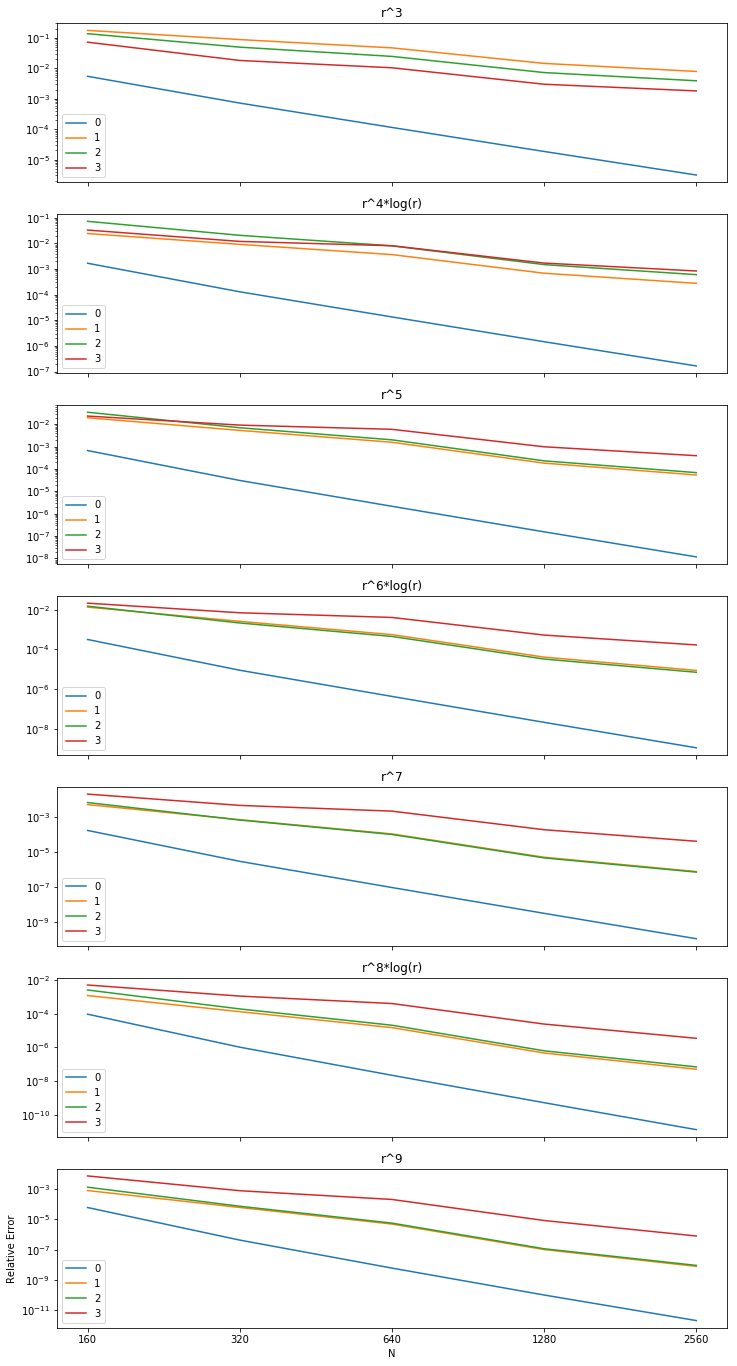

In [31]:
fig, ax_s = plt.subplots(len(rbf_labels), sharex=True, figsize=(12,24))

for i, rbf in enumerate(rbf_labels):
    legends = []
    read_data_rbf = read_data[read_data.rbf==rbf]    
    for deg in degs:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_rbf[read_data_rbf.degree==deg])
        ax_s[i].set_title(rbf)
    ax_s[i].legend( degs )
    
plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.show()

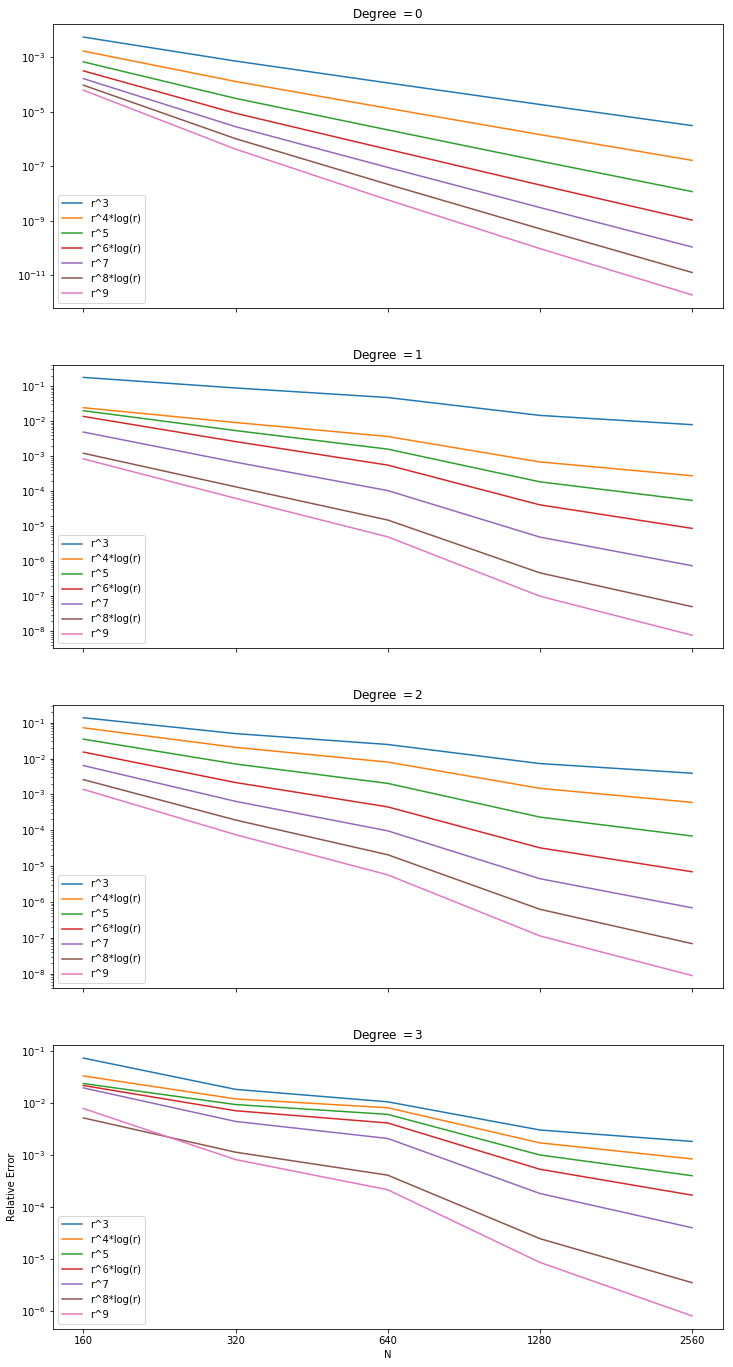

In [32]:
fig, ax_s = plt.subplots(len(degs), sharex=True, figsize=(12,24))

for i, deg in enumerate(degs):
    legends = []
    read_data_deg = read_data[read_data.degree==deg]    
    for rbf in rbf_labels:
        ax_s[i].loglog( 'N', 'rel_L2_error', data=read_data_deg[read_data_deg.rbf==rbf])
        ax_s[i].set_title('Degree $= ' + str(int(deg)) + '$')
    ax_s[i].legend( rbf_labels )
    
plt.minorticks_off()
plt.xticks(ns,ns)
plt.xlabel('N')
plt.ylabel('Relative Error')
plt.show()